<a href="https://colab.research.google.com/github/iamatul1214/LLMs/blob/main/Temperature_illustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook shows an example of how the Temperature in LLMs work.

### We would consider a simple example and some tokens in our simple vocabulary and tweak it with multiple values of temperature to see the variation in output.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Sentence prefix
prefix = "I opened my laptop and started"

# Vocabulary
tokens = ["coding", "cooking", "dancing", "working",
          "playing", "jumping", "eating", "chatting"]

# Predefined model-like probabilities (must sum to 1)
probs = np.array([0.45, 0.05, 0.03, 0.30, 0.07, 0.02, 0.05, 0.03])

# -------------------------------
#   TEMPERATURE FUNCTION
# -------------------------------
def apply_temperature(probs, T):
    scaled = probs ** (1 / T)
    return scaled / np.sum(scaled)


# -------------------------------
#   TOP-K FILTER
# -------------------------------
def top_k_filter(tokens, probs, k):
    sorted_idx = np.argsort(probs)[-k:]   # top-k
    filtered_tokens = np.array(tokens)[sorted_idx]
    filtered_probs = probs[sorted_idx]
    filtered_probs /= filtered_probs.sum()
    return filtered_tokens, filtered_probs


# -------------------------------
#   TOP-P (NUCLEUS) FILTER
# -------------------------------
def top_p_filter(tokens, probs, p):
    sorted_idx = np.argsort(probs)[::-1]
    sorted_tokens = np.array(tokens)[sorted_idx]
    sorted_probs = probs[sorted_idx]

    cumulative = np.cumsum(sorted_probs)
    cutoff = cumulative <= p

    chosen_tokens = sorted_tokens[cutoff]
    chosen_probs = sorted_probs[cutoff]

    chosen_probs /= chosen_probs.sum()
    return chosen_tokens, chosen_probs


# -------------------------------
#   SAMPLING
# -------------------------------
def sample_token(tokens, probs):
    return np.random.choice(tokens, p=probs)


# -------------------------------
#   MULTIPLE SAMPLING PER TEMPERATURE
# -------------------------------
def sample_multiple(prefix, tokens, probs, T, n=10, top_k=None, top_p=None):
    print("\n--------------------------------------------------")
    print(f"Temperature = {T}, top_k = {top_k}, top_p = {top_p}")
    print("--------------------------------------------------")

    # Step 1: Apply temperature
    p_T = apply_temperature(probs, T)

    # Print updated probabilities
    print("\nUpdated Probabilities after Temperature:")
    for tok, p in zip(tokens, p_T):
        print(f"{tok:10s}: {p:.4f}")

    # Step 2: Apply top-k
    tks, pr = tokens, p_T
    if top_k:
        tks, pr = top_k_filter(tokens, p_T, top_k)
        print("\nAfter Top-k Filtering:")
        for tok, p in zip(tks, pr):
            print(f"{tok:10s}: {p:.4f}")

    # Step 3: Apply top-p
    if top_p:
        tks, pr = top_p_filter(tokens, p_T, top_p)
        print("\nAfter Top-p Filtering:")
        for tok, p in zip(tks, pr):
            print(f"{tok:10s}: {p:.4f}")

    # Sampling N times
    print("\nGenerated Samples:")
    for _ in range(n):
        picked = sample_token(tks, pr)
        print(prefix, picked)

    return tks, pr


# -------------------------------
#   PLOT PROBABILITY SHIFT
# -------------------------------
def plot_probabilities(temperatures, probs, tokens):
    plt.figure(figsize=(11, 6))

    for T in temperatures:
        p_T = apply_temperature(probs, T)
        plt.plot(tokens, p_T, marker='o', label=f"T={T}")

    plt.title("Effect of Temperature on Token Probability Distribution")
    plt.xlabel("Tokens")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




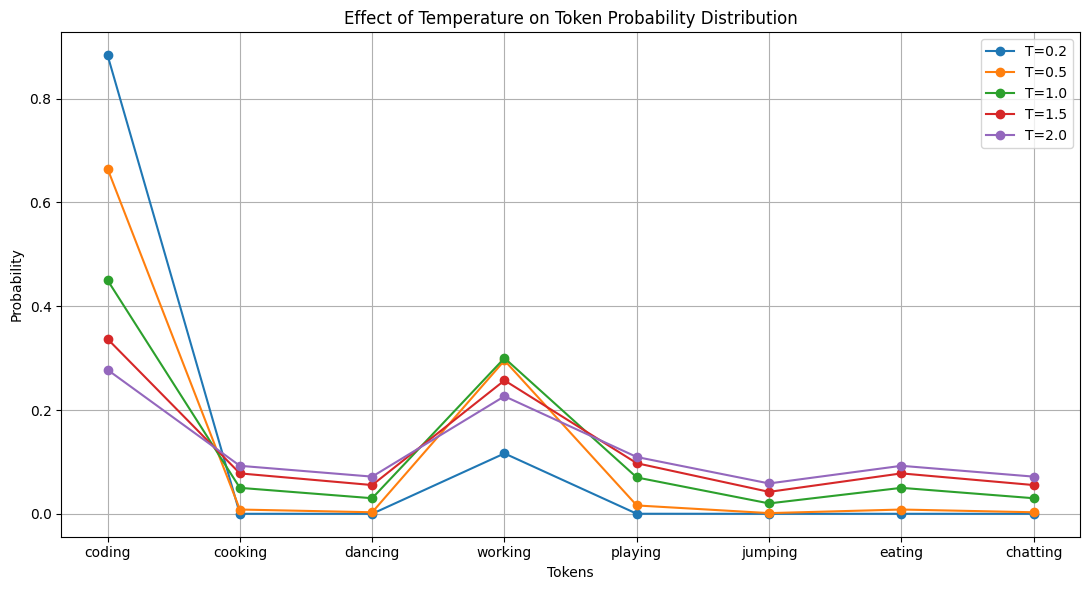


--------------------------------------------------
Temperature = 0.2, top_k = None, top_p = None
--------------------------------------------------

Updated Probabilities after Temperature:
coding    : 0.8835
cooking   : 0.0000
dancing   : 0.0000
working   : 0.1164
playing   : 0.0001
jumping   : 0.0000
eating    : 0.0000
chatting  : 0.0000

Generated Samples:
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding

--------------------------------------------------
Temperature = 0.5, top_k = None, top_p = None
--------------------------------------------------

Updated Probabilities after Temperature:
coding    : 0.6648
cooking   : 0.0082
dancing   : 0.0030
working   : 0.2955
playing   : 0.0161
jumping   : 0.0013
eating    : 0.0082
chatting  : 0.0030

Generated Samples:
I opened my laptop and started coding
I opened my laptop and started coding
I opened

(array(['coding'], dtype='<U8'), array([1.]))

In [10]:
# -------------------------------
#   RUN EVERYTHING
# -------------------------------
temperatures = [0.2, 0.5, 1.0, 1.5, 2.0]

# 1. Plot probability changes
plot_probabilities(temperatures, probs, tokens)

# 2. Print probabilities + sample outputs for each temperature
for T in temperatures:
    sample_multiple(prefix, tokens, probs, T, n=5)

# 3. Top-k example
sample_multiple(prefix, tokens, probs, T=1.0, n=5, top_k=3)

# 4. Top-p example
sample_multiple(prefix, tokens, probs, T=1.0, n=5, top_p=0.6)


## In real LLMs:

- Model outputs logits

- Temperature scaling affects logits → then softmax

### This can dramatically change which token becomes top-1 at higher T.

In [11]:
import numpy as np

# Sentence prefix
prefix = "I opened my laptop and started"

# Tokens
tokens = ["coding", "cooking", "dancing", "working",
          "playing", "jumping", "eating", "chatting"]

# Simulated LLM logits (not probabilities)
# Larger = model thinks it's more likely
logits = np.array([4.2, 1.3, 0.5, 3.7, 1.0, 0.2, 1.1, 0.4])

# -----------------------------
# Softmax from logits
# -----------------------------
def softmax(logits):
    exp = np.exp(logits - np.max(logits))  # stability
    return exp / np.sum(exp)

# -----------------------------
# Apply temperature to logits
# -----------------------------
def apply_temperature_to_logits(logits, T):
    return logits / T

# -----------------------------
# Sampling from probabilities
# -----------------------------
def sample(probs, tokens):
    return np.random.choice(tokens, p=probs)

# -----------------------------
# Main simulation per temperature
# -----------------------------
def simulate_temperature(logits, tokens, T, n_samples=10):
    print("\n==================================================")
    print(f"Temperature = {T}")
    print("==================================================")

    # Step 1: Scale logits
    scaled_logits = apply_temperature_to_logits(logits, T)

    # Step 2: Convert to probabilities
    probs = softmax(scaled_logits)

    # Step 3: Print probabilities with ranking
    print("\nUpdated probabilities:")
    sorted_idx = np.argsort(probs)[::-1]
    for idx in sorted_idx:
        print(f"{tokens[idx]:10s} : {probs[idx]:.4f}")

    # Step 4: Sample multiple outputs
    print("\nSamples:")
    for _ in range(n_samples):
        picked = sample(probs, tokens)
        print(prefix, picked)

    return probs


In [12]:
# Temperatures to test
temperatures = [0.3, 0.7, 1.0, 1.5, 2.0]

for T in temperatures:
    simulate_temperature(logits, tokens, T, n_samples=8)


Temperature = 0.3

Updated probabilities:
coding     : 0.8410
working    : 0.1589
cooking    : 0.0001
eating     : 0.0000
playing    : 0.0000
dancing    : 0.0000
chatting   : 0.0000
jumping    : 0.0000

Samples:
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started working
I opened my laptop and started coding
I opened my laptop and started coding

Temperature = 0.7

Updated probabilities:
coding     : 0.6492
working    : 0.3178
cooking    : 0.0103
eating     : 0.0077
playing    : 0.0067
dancing    : 0.0033
chatting   : 0.0028
jumping    : 0.0021

Samples:
I opened my laptop and started coding
I opened my laptop and started working
I opened my laptop and started playing
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started coding
I opened my laptop and started working
